In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import Row
from pyspark.sql.functions import year, to_date, col
from pyspark.sql.window import Window
from pyspark.sql.functions import lag



In [ ]:
!pip install findspark

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Stock Market Analysis with PySpark") \
    .getOrCreate()


In [ ]:

# Fetch Stock Data
start = '2012-01-01'
end = '2022-12-21'
stock = 'GOOG'
data = yf.download(stock, start, end)
data.reset_index(inplace=True)



[*********************100%***********************]  1 of 1 completed


In [ ]:
# Explicitly rename columns to remove ambiguity
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
spark_df = spark.createDataFrame(data[['Date', 'Close']])
spark_df = spark_df.withColumnRenamed("Date", "Date").withColumnRenamed("Close", "Close")

# Ensure Date column is in the correct format
spark_df = spark_df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
spark_df = spark_df.withColumn("Year", year(col("Date")))


In [ ]:

# MapReduce: Calculate yearly average closing prices
rdd = spark_df.rdd.map(lambda row: (row['Year'], (row['Close'], 1))) #key value pair year and value containing closin price and initiallty count is 1
reduced_rdd = rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))  #closing price, count of records of that year
averages_rdd = reduced_rdd.mapValues(lambda v: v[0] / v[1])  #CP/Count, avg cp of each year
averages = averages_rdd.collect()                     # tuple(each year:avg cp)


In [ ]:

# Display yearly average closing prices
print("Average closing price per year:")
for year, avg in averages:
    print(f"{year}: {avg}")


Average closing price per year:
2012: 15.86441427230835
2014: 27.75811263493129
2016: 36.8798952254038
2018: 55.050082795648464
2020: 73.10344558836444
2022: 114.4194779317887
2013: 21.86087161018735
2015: 29.80453015887548
2017: 45.766570437001995
2019: 58.92618657672216
2021: 124.36558968680245


In [ ]:

# Perform moving averages
ma_100_days = data.Close.rolling(100).mean()  #each day starting from 100th day and calculate mean of previous day CP
ma_200_days = data.Close.rolling(200).mean()


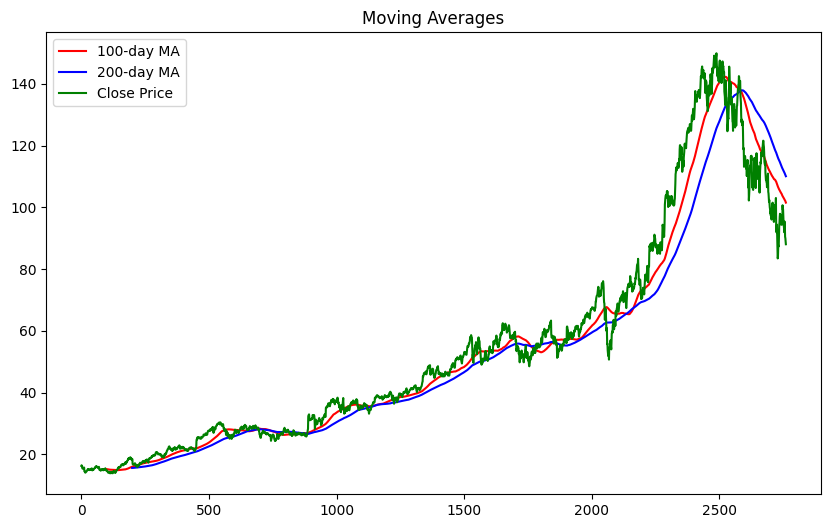

In [ ]:

# Plot moving averages
plt.figure(figsize=(10, 6))
plt.plot(ma_100_days, 'r', label='100-day MA')
plt.plot(ma_200_days, 'b', label='200-day MA')
plt.plot(data.Close, 'g', label='Close Price')
plt.legend()
plt.title("Moving Averages")
plt.show()


In [ ]:

# Prepare data for K-Means Clustering
assembler = VectorAssembler(inputCols=['Close'], outputCol='features')#close input feature for clustering,new column combined featured vectors features
kmeans_df = assembler.transform(spark_df)    


In [ ]:

# Train K-Means model
kmeans = KMeans(k=3, seed=1)  # 3 clusters
model = kmeans.fit(kmeans_df)
clusters = model.transform(kmeans_df) # transform() method takes the original data (kmeans_df) and assigns a cluster ID to each row
clusters.show()


+----------+------------------+----+--------------------+----------+
|      Date|             Close|Year|            features|prediction|
+----------+------------------+----+--------------------+----------+
|2012-01-03| 16.24834632873535|2012| [16.24834632873535]|         0|
|2012-01-04|16.453826904296875|2012|[16.453826904296875]|         0|
|2012-01-05|16.344486236572266|2012|[16.344486236572266]|         0|
|2012-01-06|  16.1840877532959|2012|  [16.1840877532959]|         0|
|2012-01-09|15.472753524780273|2012|[15.472753524780273]|         0|
|2012-01-10|15.365158081054688|2012|[15.365158081054688]|         0|
|2012-01-11|15.470014572143555|2012|[15.470014572143555]|         0|
|2012-01-12|15.604011535644531|2012|[15.604011535644531]|         0|
|2012-01-13|15.468520164489746|2012|[15.468520164489746]|         0|
|2012-01-17|15.583588600158691|2012|[15.583588600158691]|         0|
|2012-01-18| 15.49492073059082|2012| [15.49492073059082]|         0|
|2012-01-19|15.727548599243164|201

In [ ]:

# Trend Analysis using Random Forest
# Create Trend Column
windowSpec = Window.orderBy('Date')
spark_df = spark_df.withColumn('Prev_Close', lag('Close', 1).over(windowSpec)) #lag used to create new column that holds previous value of Close column for each row.
spark_df = spark_df.withColumn('Trend', (col('Close') > col('Prev_Close')).cast('int'))
spark_df = spark_df.drop('Prev_Close')


In [ ]:
# Prepare data for Random Forest Classifier
rf_assembler = VectorAssembler(inputCols=['Close'], outputCol='features') #VectorAssembler PySpark transformer combines multiple input columns into single vector column
rf_data = rf_assembler.transform(spark_df).select('features', 'Trend').withColumnRenamed('Trend', 'label')

# Ensure no missing values
rf_data = rf_data.dropna()

# Ensure correct data types
rf_data = rf_data.withColumn('label', col('label').cast('int'))

# Check schema and assembled features
rf_data.printSchema()
rf_data.select('features', 'label').show(5, truncate=False)

# Train Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=50)
rf_model = rf.fit(rf_data)

# Make predictions
rf_predictions = rf_model.transform(rf_data)
rf_predictions.show()


root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)

+--------------------+-----+
|features            |label|
+--------------------+-----+
|[16.453826904296875]|1    |
|[16.344486236572266]|0    |
|[16.1840877532959]  |0    |
|[15.472753524780273]|0    |
|[15.365158081054688]|0    |
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[16.453826904296875]|    1|[20.4069883139201...|[0.40813976627840...|       1.0|
|[16.344486236572266]|    0|[20.4069883139201...|[0.40813976627840...|       1.0|
|  [16.1840877532959]|    0|[20.4069883139201...|[0.40813976627840...|       1.0|
|[15.472753524780273]|    0|[20.4069883139201...|[0.40813976627840...|       1.0|
|[15.365158081054688]|    0|[20.4069883139201...|[0.4081

In [ ]:

# Prepare data for Linear Regression
lr_assembler = VectorAssembler(inputCols=['Close'], outputCol='features')
lr_df = lr_assembler.transform(spark_df).select('features', 'Close').withColumnRenamed('Close', 'label')
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(lr_df)


In [ ]:

# Predict prices using Linear Regression
lr_predictions = lr_model.transform(lr_df)
lr_predictions.show()


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
| [16.24834632873535]| 16.24834632873535|16.248346328735373|
|[16.453826904296875]|16.453826904296875|16.453826904296896|
|[16.344486236572266]|16.344486236572266|16.344486236572287|
|  [16.1840877532959]|  16.1840877532959| 16.18408775329592|
|[15.472753524780273]|15.472753524780273|15.472753524780293|
|[15.365158081054688]|15.365158081054688|15.365158081054707|
|[15.470014572143555]|15.470014572143555|15.470014572143574|
|[15.604011535644531]|15.604011535644531| 15.60401153564455|
|[15.468520164489746]|15.468520164489746|15.468520164489766|
|[15.583588600158691]|15.583588600158691|15.583588600158711|
| [15.49492073059082]| 15.49492073059082| 15.49492073059084|
|[15.727548599243164]|15.727548599243164|15.727548599243184|
|[14.488195419311523]|14.488195419311523|14.488195419311543|
|[14.524558067321777]|14

In [ ]:

# Train-Test Split for LSTM Model
data_train = pd.DataFrame(data.Close[0:int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80):])


In [ ]:

# Scale Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scale = scaler.fit_transform(data_train)


In [ ]:

# Prepare LSTM Data
x, y = [], []
for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i, 0])
x, y = np.array(x), np.array(y)


In [ ]:

# Build LSTM Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=50, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 340ms/step - loss: 0.0712
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - loss: 0.0076
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - loss: 0.0062
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - loss: 0.0055
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step - loss: 0.0072
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - loss: 0.0048
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - loss: 0.0049
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 360ms/step - loss: 0.0043
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 360ms/step - loss: 0.0047
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - loss: 0.0039
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 330ms/step - loss: 0.0039
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 356ms/step - loss: 0.0045
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 319ms/step - loss: 0.0035
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - loss: 0.0035
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 

In [ ]:

# Prepare Test Data
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test)
x_test, y_test = [], []
for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)


In [ ]:

# Predict using LSTM
predictions = model.predict(x_test)
predictions = predictions * (1 / scaler.scale_)
y_test = y_test * (1 / scaler.scale_)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step


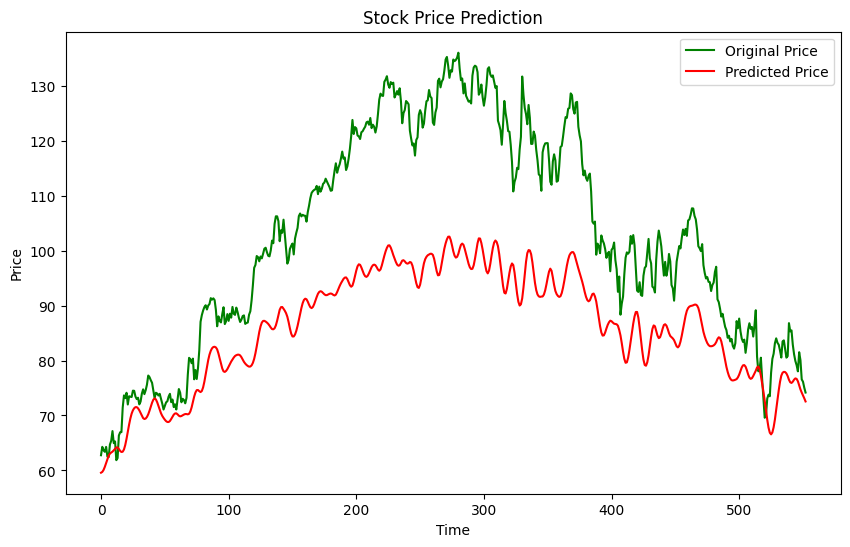

In [ ]:

# Plot Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, 'g', label='Original Price')
plt.plot(predictions, 'r', label='Predicted Price')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


In [ ]:

# Save Model
model.save('Stock_Predictions_Model.keras')


In [33]:
!pip install streamlit
!pip install yfinance
!pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00
